In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import v2

In [2]:
from pathlib import Path
import shutil
import tqdm
from ultralytics import YOLO
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from typing import Union
import os



In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [4]:
lidar_images = Path("/cluster/projects/vc/data/ad/open/Poles")

In [5]:

def print_directory_structure(startpath):
    for root, dirs, files in os.walk(startpath):
        level = root.replace(startpath, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)
        for f in files:
            print(f'{subindent}{f}')
            break

print_directory_structure(str(lidar_images))


Poles/
    README.dataset.txt
    test/
        labels/
            combined_image_977_png.rf.c5f3053e13600d351f6be75e1b9757a5.txt
        images/
            combined_image_252_png.rf.135ceef664dba8daecdb41f98d115755.jpg
    train/
        .DS_Store
        labels/
            Image00658_rgb_png.rf.924d3162454c4a246eb1a7dbcc3b4400.txt
        images/
            combined_image_1249_png.rf.545e8638623ae9229dd267c0b1bbae68.jpg


In [6]:
model = YOLO("yolo11s.pt")

In [7]:
if not (Path.cwd() / "data").exists():
    tqdm.tqdm(shutil.copytree(lidar_images, Path.cwd() / "data"))
    print(f"Files copied to {Path.cwd() / 'data'}")
else:
    print(f"Files already present in {Path.cwd() / 'data'}")

Files already present in /cluster/home/jofa/tdt17/TDT17-mini-project/data


In [8]:
img_path = "data/test/images/combined_image_5_png.rf.9372598b5abf9cfff473ec530fdbf7be.jpg"
coord_path = "data/test/labels/combined_image_5_png.rf.9372598b5abf9cfff473ec530fdbf7be.txt"

double_coords_path = "data/test/labels/combined_image_13_png.rf.7390c64ced5859039424843ebf4207f9.txt"

In [9]:
#this only works for files with a single line of coordinates

def get_coords(file_path):
    with open(file_path, 'r') as file:
        file_contents = file.read()
        
        
    if "\n" in file_contents:
        # print(f"File {file_path} contains multiple lines of coordinates")
        file_contents = file_contents.split("\n")
        # print(f"file_contents: {file_contents}")
        for i, index in enumerate(file_contents):
            file_contents[i] = index.split(" ")
            for j, index2 in enumerate(file_contents[i]):
                file_contents[i][j] = float(index2)
        return file_contents
    else:    
        file_contents = file_contents.split(" ")
        for i, index in enumerate(file_contents):
            file_contents[i] = float(index)
        return [file_contents, None]


print(f"Function output:\n{get_coords(coord_path)}")
print(f"Function output:\n{get_coords(double_coords_path)}")

print(f"Expected coords:\n0 0.42138671875 0.74609375 0.0068359375 0.2421875\n0 0.5244140625 0.6484375 0.00537109375 0.1640625")

Function output:
[[0.0, 0.21875, 0.9140625, 0.0078125, 0.171875], None]
Function output:
[[0.0, 0.42138671875, 0.74609375, 0.0068359375, 0.2421875], [0.0, 0.5244140625, 0.6484375, 0.00537109375, 0.1640625]]
Expected coords:
0 0.42138671875 0.74609375 0.0068359375 0.2421875
0 0.5244140625 0.6484375 0.00537109375 0.1640625


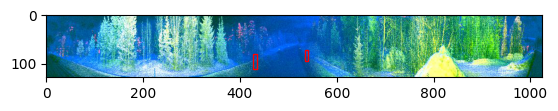

Image shape: (128, 1024, 3)


In [10]:
def show_boxes(image, box_coords):
    
    # print(f"Box coords: {box_coords}")
    fig, ax = plt.subplots()
    for i, box in enumerate(box_coords):
        # print(f"Box {i}: {box}")
        if box is None:
            # print("Finished printing rectangles")
            pass
        else:
            # print(i)
            _, x_center, y_center, width, height = box
            
            # print(f"Image shape: {image.shape[:2]}")
            img_height, img_width = image.shape[:2]
            
            
            # print(f"Box coordinates:  x_center: {x_center}, y_center: {y_center}, width: {width}, height: {height}")
            # print(f"Type: {type(x_center)}")

            x_center *= img_width
            y_center *= img_height
            width *= img_width
            height *= img_height
            
            # print(f"Box coordinates:  x_center: {x_center}, y_center: {y_center}, width: {width}, height: {height}")
            x1 = x_center - width / 2
            y1 = y_center - height / 2
            
            rect = patches.Rectangle((x1, y1), width, height, linewidth=1, edgecolor='r', facecolor='none')
            
            ax.add_patch(rect)
    
    ax.set_xlim(0, img_width)
    ax.set_ylim(img_height, 0)
    plt.imshow(image)
    
    plt.pause(0.001)
    
show_boxes(plt.imread(img_path), get_coords(double_coords_path))
print(f"Image shape: {plt.imread(img_path).shape}")

In [11]:
class LidarDataset(Dataset):
    """Custom dataset for LiDAR images"""
    
    def __init__(self, img_dir:Union[Path, str], coord_dir:Union[Path, str], transform=None):
        
        self.img_dir = img_dir
        self.coord_dir = coord_dir
        self.transform = transform
        
        self.images = sorted(os.listdir(img_dir))
        self.coords = sorted(os.listdir(coord_dir))
        if len(self.images) != len(self.coords):
            raise ValueError("Number of images and coordinates do not match")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_path = os.path.join(self.img_dir, self.images[idx])
        coord_path = os.path.join(self.coord_dir, self.coords[idx])
        
        image = plt.imread(img_path)
        coords = get_coords(coord_path)
        
        if coords[-1] == None:
            coords = coords[:-1]
        
        if self.transform:
            image = self.transform(image)
        
        print(f"Image path: {img_path}")
        print(f"Coord path: {coord_path}")
        return image, coords

Image path: data/test/images/Image00484_rgb_png.rf.c0bf400a339d3e7a8f513beac2d88820.jpg
Coord path: data/test/labels/Image00484_rgb_png.rf.c0bf400a339d3e7a8f513beac2d88820.txt


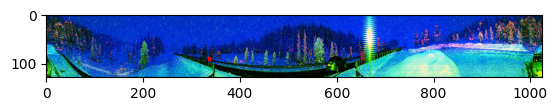

Image path: data/test/images/Image00486_rgb_png.rf.3f0a783a26091b0efb052323f801a6ff.jpg
Coord path: data/test/labels/Image00486_rgb_png.rf.3f0a783a26091b0efb052323f801a6ff.txt


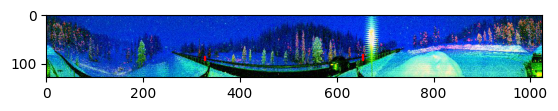

Image path: data/test/images/Image00488_rgb_png.rf.ded5a4deda344abfa4e3942cc80d2f43.jpg
Coord path: data/test/labels/Image00488_rgb_png.rf.ded5a4deda344abfa4e3942cc80d2f43.txt


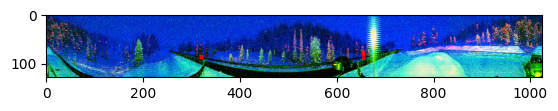

Image path: data/test/images/Image00504_rgb_png.rf.f38a3c8edfb01fec6d2f746932100585.jpg
Coord path: data/test/labels/Image00504_rgb_png.rf.f38a3c8edfb01fec6d2f746932100585.txt


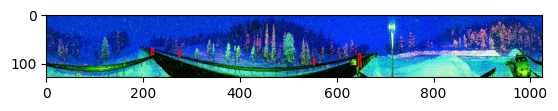

Image path: data/test/images/Image00505_rgb_png.rf.740d4636d1bc54bd1836bdfc3298327e.jpg
Coord path: data/test/labels/Image00505_rgb_png.rf.740d4636d1bc54bd1836bdfc3298327e.txt


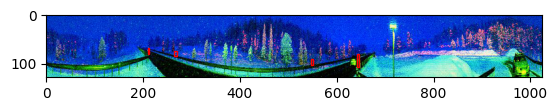

Image path: data/test/images/Image00509_rgb_png.rf.0023d73e44e8833044c32a60a5d4a7d6.jpg
Coord path: data/test/labels/Image00509_rgb_png.rf.0023d73e44e8833044c32a60a5d4a7d6.txt


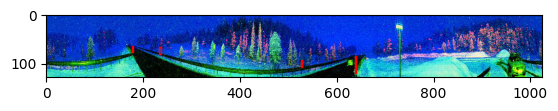

In [12]:
lidar_dataset = LidarDataset(Path("data/test/images"), Path("data/test/labels"))

for i, sample in enumerate(lidar_dataset):
    show_boxes(sample[0], sample[1])
    if i == 5:
        break

In [13]:
transforms = v2.Compose([
    v2.Resize(size=(64, 512), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]) 

Image path: data/test/images/Image00484_rgb_png.rf.c0bf400a339d3e7a8f513beac2d88820.jpg
Coord path: data/test/labels/Image00484_rgb_png.rf.c0bf400a339d3e7a8f513beac2d88820.txt


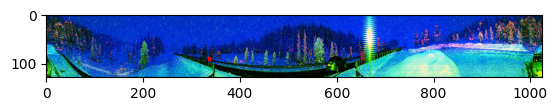

Image path: data/test/images/Image00486_rgb_png.rf.3f0a783a26091b0efb052323f801a6ff.jpg
Coord path: data/test/labels/Image00486_rgb_png.rf.3f0a783a26091b0efb052323f801a6ff.txt


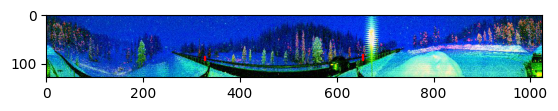

Image path: data/test/images/Image00488_rgb_png.rf.ded5a4deda344abfa4e3942cc80d2f43.jpg
Coord path: data/test/labels/Image00488_rgb_png.rf.ded5a4deda344abfa4e3942cc80d2f43.txt


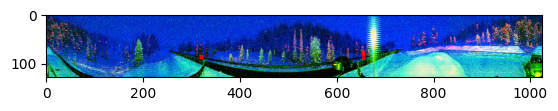

Image path: data/test/images/Image00504_rgb_png.rf.f38a3c8edfb01fec6d2f746932100585.jpg
Coord path: data/test/labels/Image00504_rgb_png.rf.f38a3c8edfb01fec6d2f746932100585.txt


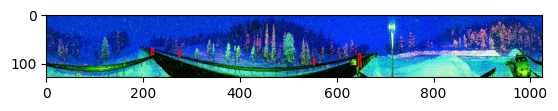

Image path: data/test/images/Image00505_rgb_png.rf.740d4636d1bc54bd1836bdfc3298327e.jpg
Coord path: data/test/labels/Image00505_rgb_png.rf.740d4636d1bc54bd1836bdfc3298327e.txt


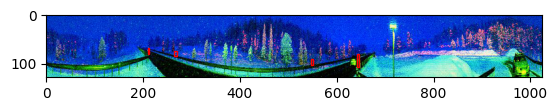

Image path: data/test/images/Image00509_rgb_png.rf.0023d73e44e8833044c32a60a5d4a7d6.jpg
Coord path: data/test/labels/Image00509_rgb_png.rf.0023d73e44e8833044c32a60a5d4a7d6.txt


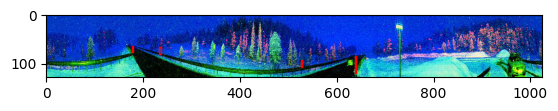

In [14]:
transformed_dataset = LidarDataset(Path("data/test/images"), Path("data/test/labels"), transform=transforms)

for i, sample in enumerate(lidar_dataset):
    show_boxes(sample[0], sample[1])
    if i == 5:
        break

In [15]:
del lidar_dataset
del transformed_dataset

In [ ]:
# # Create validation folder if it doesn't exist
# # val_folder.mkdir(parents=True, exist_ok=True)

# DEBUG = False
# # Define the paths
# if DEBUG:
#     images_folder = Path("data/train/images")
#     labels_folder = Path("data/train/labels")
#     train_images_folder = Path("data/training/images")
#     train_labels_folder = Path("data/training/labels")
#     val_images_folder = Path("data/valid/images")
#     val_labels_folder = Path("data/valid/labels")

#     # Create directories if they don't exist
#     train_images_folder.mkdir(parents=True, exist_ok=True)
#     train_labels_folder.mkdir(parents=True, exist_ok=True)
#     val_images_folder.mkdir(parents=True, exist_ok=True)
#     val_labels_folder.mkdir(parents=True, exist_ok=True)

#     # Get list of all image and label files
#     image_files = sorted(images_folder.glob("*.jpg")) 
#     label_files = sorted(labels_folder.glob("*.txt")) 

#     # Ensure that the number of images and labels match
#     assert len(image_files) == len(label_files), "Number of images and labels do not match"

#     # Split the data into training and validation sets
#     train_images, val_images, train_labels, val_labels = train_test_split(
#         image_files, label_files, test_size=0.2, random_state=42
#     )

#     # Function to copy files to the respective directories
#     def copy_files(files, dest_folder):
#         for file in files:
#             shutil.copy(file, dest_folder)

#     # Copy the files to the respective directories
#     copy_files(train_images, train_images_folder)
#     copy_files(train_labels, train_labels_folder)
#     copy_files(val_images, val_images_folder)
#     copy_files(val_labels, val_labels_folder)

#     print("Data split and copied successfully.")

: 

In [ ]:
model = YOLO("yolov10n.pt")

results = model.train(data="/cluster/home/jofa/tdt17/TDT17-mini-project/data/data.yaml",
                      epochs=1,
                      batch=8,
                      workers=0,
                      imgsz=1024,
                      )
# model.val(batch=1,
#           workers=0,
#           )


Ultralytics 8.3.33 🚀 Python-3.11.10 torch-2.5.1 CUDA:0 (NVIDIA A100 80GB PCIe, 81158MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/cluster/home/jofa/tdt17/TDT17-mini-project/data/data.yaml, epochs=1, time=None, patience=100, batch=8, imgsz=1024, save=True, save_period=-1, cache=False, device=None, workers=0, project=None, name=train41, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, sho

train: Scanning /cluster/home/jofa/tdt17/TDT17-mini-project/data/training/labels.cache... 1447 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1447/1447 [00:00<?, ?it/s]
val: Scanning /cluster/home/jofa/tdt17/TDT17-mini-project/data/valid/labels.cache... 362 images, 0 backgrounds, 0 corrupt: 100%|██████████| 362/362 [00:00<?, ?it/s]


Plotting labels to runs/detect/train41/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 0 dataloader workers
Logging results to runs/detect/train41
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1      3.69G      5.822      19.51       2.44         13       1024: 100%|██████████| 181/181 [01:09<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   4%|▍         | 1/23 [00:00<00:13,  1.68it/s]

In [ ]:
print(results)

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f677c4784d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [ ]:
# Log box loss and mAP50-95
box_loss = results.box.loss
map50_95 = results.metrics['metrics/mAP50-95(B)']

print(f"Box Loss: {box_loss}")
print(f"mAP50-95: {map50_95}")

# If you are using a logging tool like wandb, you can log these metrics as follows:
# wandb.log({"Box Loss": box_loss, "mAP50-95": map50_95})

NameError: name 'results' is not defined

In [ ]:
print(type(results.metrics))
# wandb.log({"mAP50-95": results.metrics['mAP50-95']})


AttributeError: 'DetMetrics' object has no attribute 'metrics'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP) of an
    object detection model.

    Args:
        save_dir (Path): A path to the directory where the output plots will be saved. Defaults to current directory.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class. Defaults to False.
        on_plot (func): An optional callback to pass plots path and data when they are rendered. Defaults to None.
        names (dict of str): A dict of strings that represents the names of the classes. Defaults to an empty tuple.

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot the precision-recall curves for each class.
        on_plot (func): An optional callback to pass plots path and data when they are rendered.
        names (dict of str): A dict of strings that represents the names of the classes.
        box (Metric): An instance of the Metric class for storing the results of the detection metrics.
        speed (dict): A dictionary for storing the execution time of different parts of the detection process.

    Methods:
        process(tp, conf, pred_cls, target_cls): Updates the metric results with the latest batch of predictions.
        keys: Returns a list of keys for accessing the computed detection metrics.
        mean_results: Returns a list of mean values for the computed detection metrics.
        class_result(i): Returns a list of values for the computed detection metrics for a specific class.
        maps: Returns a dictionary of mean average precision (mAP) values for different IoU thresholds.
        fitness: Computes the fitness score based on the computed detection metrics.
        ap_class_index: Returns a list of class indices sorted by their average precision (AP) values.
        results_dict: Returns a dictionary that maps detection metric keys to their computed values.
        curves: TODO
        curves_results: TODO
    

: 

In [ ]:
# data_yaml_path = Path.cwd() / "data" / "data.yaml"

# if data_yaml_path.exists():
# 	try:
# 		results = model.train(data=str(data_yaml_path), epochs=3)
# 	except Exception as e:
# 		print(f"An error occurred during training: {e}")
# else:
# 	print(f"data.yaml file not found at {data_yaml_path}")

In [ ]:
# results = model.val()